## Homework 4

Use this notebook as a starter

In [18]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [19]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

--2021-10-03 12:22:58--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv.2’

CreditScoring.csv.2 100%[===================>] 178.21K  --.-KB/s    in 0.04s   

2021-10-03 12:22:58 (3.96 MB/s) - ‘CreditScoring.csv.2’ saved [182489/182489]



## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [20]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [21]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [22]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [23]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [24]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [25]:
df.dtypes

seniority     int64
home         object
time          int64
age           int64
marital      object
records      object
job          object
expenses      int64
income        int64
assets        int64
debt          int64
amount        int64
price         int64
default       int64
dtype: object

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [26]:
numerical = ['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 'amount', 'price', 'default']
categorical = ['home', 'marital', 'records', 'job']

In [27]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1)
df_full_train = df_full_train.reset_index()
df_train = df_train.reset_index()
df_val = df_val.reset_index()
df_test = df_test.reset_index()

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [28]:
from sklearn.metrics import roc_auc_score

numerical_auc = numerical.copy()
numerical_auc.remove('default')

for x in numerical_auc:
    if roc_auc_score(df_train['default'], df_train[x]) < 0.5: 
        print (x, roc_auc_score(df_train['default'], -df_train[x]))
    else:
        print (x, roc_auc_score(df_train['default'], df_train[x]))
        

seniority 0.7093778624491943
time 0.5608662489595051
age 0.5732933272499939
expenses 0.5009184217217011
income 0.682006666132633
assets 0.6486042567122802
debt 0.5047829675783548
amount 0.5910773431595518
price 0.5043329862114843


Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [29]:
selected_columns = ['seniority', 'income', 'assets', 'records', 'job', 'home']
df_full_train_selected = df_full_train[selected_columns]
df_train_selected = df_train[selected_columns]
df_test_selected = df_test[selected_columns]
df_val_selected = df_val[selected_columns]

In [30]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse = False)

train_dict = df_train_selected.to_dict(orient = 'records')
y_train = df_train.default.values

X_train = dv.fit_transform(train_dict)

from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver = 'liblinear', C = 1.0, max_iter = 1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [31]:
val_dict = df_val[selected_columns].to_dict(orient = 'records')

y_val = df_val.default.values

del df_val['default']

X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

roc_auc_score(y_val, y_pred)

0.8120879813449298

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

/tmp/ipykernel_5267/3522982320.py:13: RuntimeWarning: invalid value encountered in long_scalars
  precision = true_positive / (true_positive + false_positive)


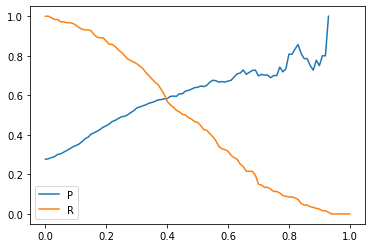

In [40]:
scores  = []

thresholds = np.linspace(0,1,101)

for i in thresholds: 
    
    true_positive = ((y_val == 1) & (y_pred >= i)).sum()
    true_negative = ((y_val == 0) & (y_pred < i)).sum()
    
    false_positive = ((y_val == 0) & (y_pred >= i)).sum()
    false_negative = ((y_val == 1) & (y_pred < i)).sum()
    
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    
    scores.append((i, precision, recall))

columns = ['threshold', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)

plt.plot(df_scores.threshold, df_scores.precision, label='P')
plt.plot(df_scores.threshold, df_scores.recall, label='R')
plt.legend()


At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [46]:
scores  = []

thresholds = np.linspace(0,1,101)

for i in thresholds: 
    
    true_positive = ((y_val == 1) & (y_pred >= i)).sum()
    true_negative = ((y_val == 0) & (y_pred < i)).sum()
    
    false_positive = ((y_val == 0) & (y_pred >= i)).sum()
    false_negative = ((y_val == 1) & (y_pred < i)).sum()
    
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    
    f1 = 2 * (precision * recall) / (precision + recall)
    
    scores.append((i, precision, recall, f1))
    
columns = ['threshold', 'precision', 'recall', 'f1_score']
df_scores = pd.DataFrame(scores, columns = columns)    



/tmp/ipykernel_5267/1965515142.py:13: RuntimeWarning: invalid value encountered in long_scalars
  precision = true_positive / (true_positive + false_positive)


In [49]:
df_scores['f1_score'].max()
df_scores[df_scores['f1_score'] == df_scores['f1_score'].max()].threshold

30    0.3
Name: threshold, dtype: float64

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [58]:
from sklearn.model_selection import KFold 

def train(df_train, y_train, C=1.0):
    dicts = df_train[selected_columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver = 'liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[selected_columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.default.values
    y_val = df_val.default.values

    dv, model = train(df_train, y_train, C=1)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    

In [59]:
scores
scores_std = np.array(scores).std()
scores_std

0.014621634477450657

Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [61]:
n_splits = 5

for C in [0.01, 0.1, 1, 10]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv, model = train(df_train, y_train, C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print (C, np.std(scores), np.mean(scores))
    

0.01 0.012548518158618608 0.8085509410381417
0.1 0.013735891744384743 0.8129091022286496
1 0.014621634477450657 0.8141729236561777
10 0.014725739424286836 0.8133021418714865


## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.